In [1]:
import pandas as pd


In [2]:
scored_variants = pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/blood_traits/enformer_predictions.tsv", sep="\t", header=0)


In [3]:
scored_variants

,chr,pos,ref,alt,rsid,DNASE_SAD,DNASE_SAR,CAGE_SAD_4828,CAGE_SAR_4828,CAGE_SAD_5111,CAGE_SAR_5111
0,chr1,11012,C,G,rs544419019,0.000217,0.000304,0.001164,0.001593,0.002567,0.003328
1,chr1,13110,G,A,rs540538026,-0.000036,-0.000051,-0.000100,-0.000137,-0.000312,-0.000402
2,chr1,13116,T,G,rs62635286,-0.000013,-0.000018,-0.000108,-0.000148,-0.000253,-0.000327
3,chr1,13118,A,G,rs200579949,0.000020,0.000028,0.000077,0.000105,0.000263,0.000340
4,chr1,13273,G,C,rs531730856,0.000056,0.000078,0.000225,0.000305,0.000451,0.000569
...,...,...,...,...,...,...,...,...,...,...,...
9840763,chr21,48116032,A,C,rs141010241,0.000055,0.000076,-0.000015,-0.000020,-0.000016,-0.000021
9840764,chr21,48117699,C,G,rs11910421,-0.000055,-0.000076,-0.000102,-0.000137,-0.000175,-0.000229
9840765,chr21,48118443,T,G,rs533222456,0.000340,0.000468,0.000126,0.000170,0.000317,0.000416
9840766,chr21,48119252,G,A,rs199868906,-0.001922,-0.002650,0.001087,0.001470,-0.000301,-0.000397


In [21]:
import matplotlib


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [12, 10]

def plot_enrichment_curves(df, compare_score, model_score, output_file, compare_score_ascending=False, model_score_ascending=True,
                           thresh_list=[0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], subsample=False, ymax='auto', debug=False):
    by_thresh_dict = {'score':[], 'ratio':[], 'thresh':[]}
    
    df[model_score+"_abs"] = np.abs(df[model_score])
    model_score = model_score+"_abs"
    print(model_score)
    thresh_list = [df[model_score].quantile(1-0.5), df[model_score].quantile(1-0.1), df[model_score].quantile(1-0.05), df[model_score].quantile(1-0.01),
                  df[model_score].quantile(1-0.005), df[model_score].quantile(1-0.001), df[model_score].quantile(1-0.0005), df[model_score].quantile(1-0.0001)]
    print(thresh_list)
    for thresh in thresh_list:
        df[compare_score].fillna(0, inplace=True)
        sample_df = df.sort_values(by=[compare_score, model_score], ascending=[False, False])
        #print(sample_df.head())
        #print(sample_df.tail())
        ratio = len(sample_df.loc[sample_df[model_score] > thresh]) / len(sample_df)
        sample_df['sig'] = sample_df[model_score].apply(lambda x: x > thresh)
        sample_df['expected'] = [ratio] * len(sample_df)
        expected = sample_df['expected'].cumsum().tolist()
        observed = sample_df['sig'].cumsum().tolist()
        
        enrich_ratio = np.array(observed) / np.array(expected)
        compare_vals = sample_df[compare_score].tolist()
        enrich_ratio = enrich_ratio.tolist()
        assert len(compare_vals) == len(enrich_ratio)
        by_thresh_dict['ratio'].extend(enrich_ratio)
        by_thresh_dict['score'].extend(compare_vals)
        by_thresh_dict['thresh'].extend([thresh] * len(sample_df))
        
        if debug:
            print(thresh)
            print('Expected:', expected[:10])
            print('Observed:', observed[:10])
            print('Ratio:', enrich_ratio[:10])
            print('Compare Scores:', compare_vals[:10])
            print()
        
    by_thresh_df = pd.DataFrame(by_thresh_dict)
    by_thresh_df.sort_values(by=['score'], ascending=False, inplace=True)
    if subsample:
        by_thresh_df = pd.concat([by_thresh_df.iloc[:20000,].copy(), by_thresh_df.iloc[20000:,].copy().sample(30000)])
    ax = sns.lineplot(data=by_thresh_df, x='score', y='ratio', linewidth=3, ci=None,
                      hue='thresh', palette=sns.color_palette('rocket', 8))
    leg = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    for line in leg.get_lines():
        line.set_linewidth(4)
    if str(ymax) != 'auto':
        ax.set(title=compare_score + ' vs ' + model_score, xlabel=compare_score, ylabel='observed / expected', ylim=(0, ymax))
    else:
        ax.set(title=compare_score + ' vs ' + model_score, xlabel=compare_score, ylabel='observed / expected')
    plt.savefig("subfigs/"+output_file, transparent=True, dpi=300)

In [5]:
scored_variants

,chr,pos,ref,alt,rsid,DNASE_SAD,DNASE_SAR,CAGE_SAD_4828,CAGE_SAR_4828,CAGE_SAD_5111,CAGE_SAR_5111
0,chr1,11012,C,G,rs544419019,0.000217,0.000304,0.001164,0.001593,0.002567,0.003328
1,chr1,13110,G,A,rs540538026,-0.000036,-0.000051,-0.000100,-0.000137,-0.000312,-0.000402
2,chr1,13116,T,G,rs62635286,-0.000013,-0.000018,-0.000108,-0.000148,-0.000253,-0.000327
3,chr1,13118,A,G,rs200579949,0.000020,0.000028,0.000077,0.000105,0.000263,0.000340
4,chr1,13273,G,C,rs531730856,0.000056,0.000078,0.000225,0.000305,0.000451,0.000569
...,...,...,...,...,...,...,...,...,...,...,...
9840763,chr21,48116032,A,C,rs141010241,0.000055,0.000076,-0.000015,-0.000020,-0.000016,-0.000021
9840764,chr21,48117699,C,G,rs11910421,-0.000055,-0.000076,-0.000102,-0.000137,-0.000175,-0.000229
9840765,chr21,48118443,T,G,rs533222456,0.000340,0.000468,0.000126,0.000170,0.000317,0.000416
9840766,chr21,48119252,G,A,rs199868906,-0.001922,-0.002650,0.001087,0.001470,-0.000301,-0.000397


In [6]:
#blood_variants=pd.read_csv("/mnt/lab_data2/anusri/signed_variant_scorer/variant-scorer/output/blood_traits/SNP_info_table.tsv", sep="\t", header=0)
blood_variants=pd.read_csv("/oak/stanford/groups/akundaje/projects/igvf-fcc/data/rosa/SNP_info_table.blood.superset.tsv", sep="\t", header=0)

In [7]:
def flatten(l):
    return [item for sublist in l for item in sublist]

import numpy as np


set(flatten(blood_variants['traits'].str.split("|").values.tolist()))

{'Hb', 'HbA1c', 'MCH', 'MCHC', 'MCV', 'Plt', 'RBC', 'WBC'}

In [8]:
scored_variants.shape

(9840768, 11)

In [9]:
blood_variants.shape

(83269, 6)

In [10]:
final1 = scored_variants.merge(blood_variants, how="left", left_on=["rsid", "alt", "ref"], right_on=["rsid", "allele1", "allele2"])
final2 = scored_variants.merge(blood_variants, how="left", left_on=["rsid", "ref", "alt"], right_on=["rsid", "allele1", "allele2"])



In [11]:
vals = np.isnan(final1["maxPIP"]) & ~np.isnan(final2["maxPIP"])

In [12]:
sum(vals)

59870

In [13]:
final1

,chr,pos,ref,alt,rsid,DNASE_SAD,DNASE_SAR,CAGE_SAD_4828,CAGE_SAR_4828,CAGE_SAD_5111,CAGE_SAR_5111,allele1,allele2,traits,IDs,maxPIP
0,chr1,11012,C,G,rs544419019,0.000217,0.000304,0.001164,0.001593,0.002567,0.003328,NaN,NaN,NaN,NaN,NaN
1,chr1,13110,G,A,rs540538026,-0.000036,-0.000051,-0.000100,-0.000137,-0.000312,-0.000402,NaN,NaN,NaN,NaN,NaN
2,chr1,13116,T,G,rs62635286,-0.000013,-0.000018,-0.000108,-0.000148,-0.000253,-0.000327,NaN,NaN,NaN,NaN,NaN
3,chr1,13118,A,G,rs200579949,0.000020,0.000028,0.000077,0.000105,0.000263,0.000340,NaN,NaN,NaN,NaN,NaN
4,chr1,13273,G,C,rs531730856,0.000056,0.000078,0.000225,0.000305,0.000451,0.000569,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9840763,chr21,48116032,A,C,rs141010241,0.000055,0.000076,-0.000015,-0.000020,-0.000016,-0.000021,NaN,NaN,NaN,NaN,NaN
9840764,chr21,48117699,C,G,rs11910421,-0.000055,-0.000076,-0.000102,-0.000137,-0.000175,-0.000229,NaN,NaN,NaN,NaN,NaN
9840765,chr21,48118443,T,G,rs533222456,0.000340,0.000468,0.000126,0.000170,0.000317,0.000416,NaN,NaN,NaN,NaN,NaN
9840766,chr21,48119252,G,A,rs199868906,-0.001922,-0.002650,0.001087,0.001470,-0.000301,-0.000397,NaN,NaN,NaN,NaN,NaN


In [14]:
final1.loc[vals, ["maxPIP", "allele1", "allele2", "traits", "IDs"]] = final2[~np.isnan(final2["maxPIP"])][["maxPIP", "allele1", "allele2", "traits", "IDs"]]




In [15]:
final1.shape

(9840768, 16)

In [16]:

final1.count()

chr              9840768
pos              9840768
ref              9840768
alt              9840768
rsid             9840768
DNASE_SAD        9840768
DNASE_SAR        9840768
CAGE_SAD_4828    9840768
CAGE_SAR_4828    9840768
CAGE_SAD_5111    9840768
CAGE_SAR_5111    9840768
allele1            83203
allele2            83203
traits             83203
IDs                83203
maxPIP             83203
dtype: int64

In [17]:
final1['DNASE_SAD'].quantile(0.001)

-0.001594

DNASE_SAD_abs
[1.156e-05, 9.86e-05, 0.0001738, 0.000533, 0.000836, 0.002274, 0.003359, 0.007439616499999539]


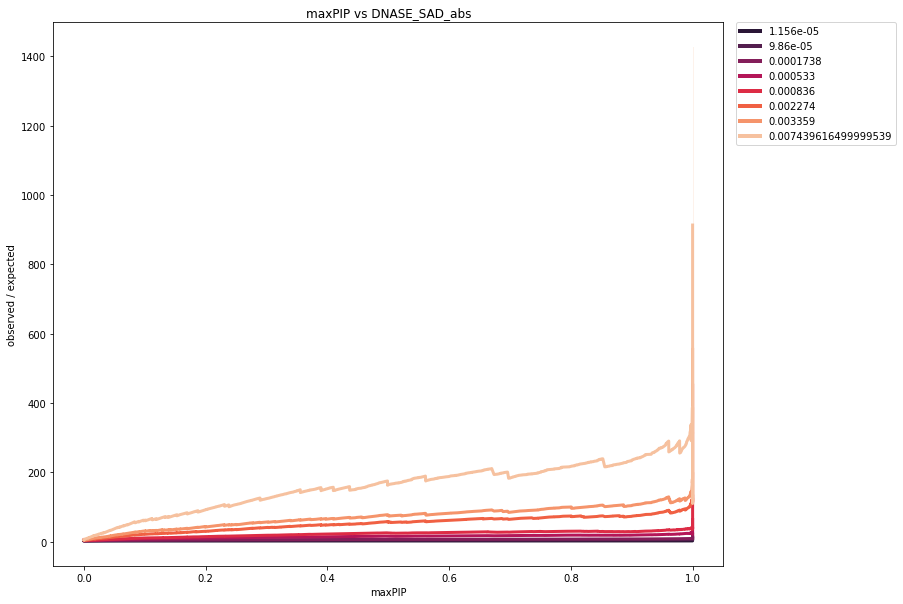

In [18]:
final = final1
import numpy as np
import seaborn as sns

plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='DNASE_SAD',
                       compare_score_ascending=False, model_score_ascending=False, output_file="enformer_dnase_sad_bloodtraits_abs_logfc_x_jsd_x_max_percentile.pdf")

DNASE_SAR_abs
[1.59e-05, 0.0001278, 0.0002222, 0.0006676, 0.00104, 0.002813, 0.004147, 0.009218465999998152]


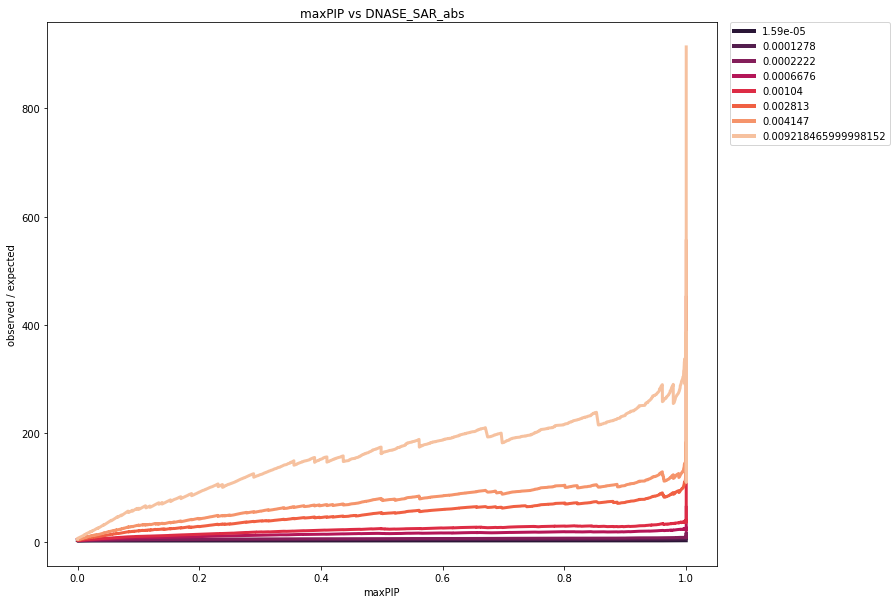

In [22]:
final = final1
import numpy as np
import seaborn as sns

plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='DNASE_SAR',
                       compare_score_ascending=False, model_score_ascending=False, output_file="enformer_dnase_sar_bloodtraits_abs_logfc_x_jsd_x_max_percentile.pdf")

CAGE_SAD_5111_abs
[1.895e-05, 0.000286, 0.0005636, 0.001928, 0.003086, 0.00876, 0.01337, 0.03198]


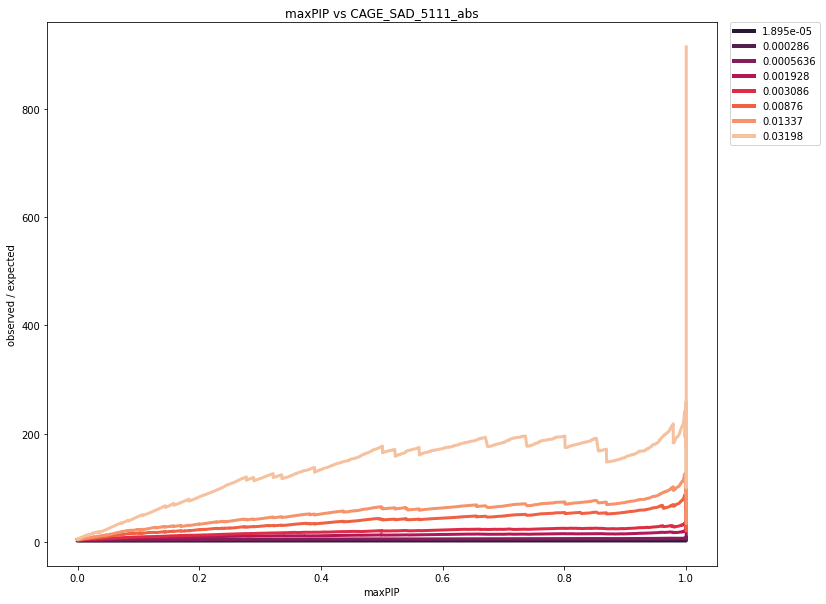

In [23]:
final = final1
import numpy as np
import seaborn as sns

plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='CAGE_SAD_5111',
                       compare_score_ascending=False, model_score_ascending=False, output_file="enformer_cage_5111_sad_bloodtraits_abs_logfc_x_jsd_x_max_percentile.pdf")

CAGE_SAR_5111_abs
[2.515e-05, 0.0002828, 0.0005255, 0.001682, 0.002651, 0.00738, 0.011256165000014006, 0.02718]


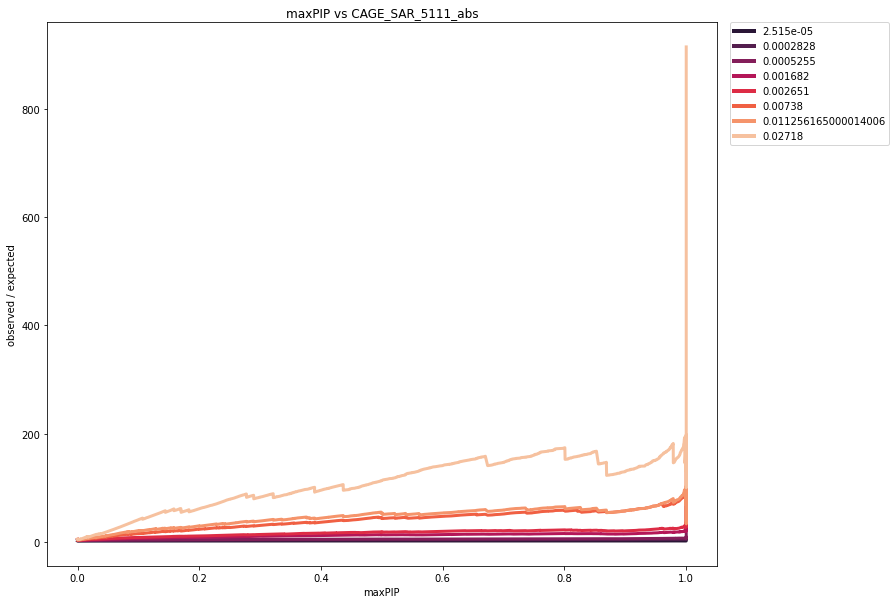

In [24]:
final = final1
import numpy as np
import seaborn as sns

plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='CAGE_SAR_5111',
                       compare_score_ascending=False, model_score_ascending=False, output_file="enformer_cage_5111_sar_bloodtraits_abs_logfc_x_jsd_x_max_percentile.pdf")

CAGE_SAD_4828_abs
[1.31e-05, 0.0001543, 0.0002952, 0.0009723, 0.001542, 0.004272, 0.006573, 0.01624]


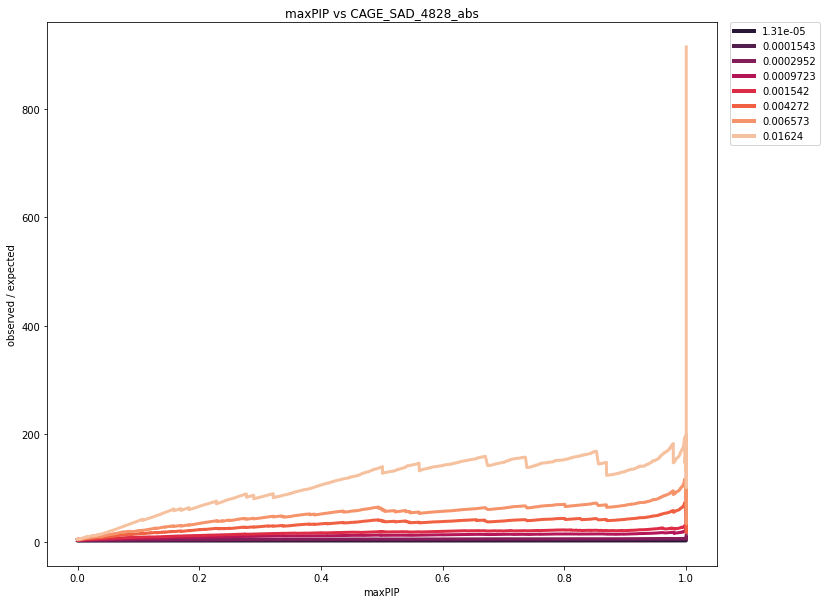

In [25]:
final = final1
import numpy as np
import seaborn as sns

plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='CAGE_SAD_4828',
                       compare_score_ascending=False, model_score_ascending=False, output_file="enformer_cage_4828_sad_bloodtraits_abs_logfc_x_jsd_x_max_percentile.pdf")

CAGE_SAR_4828_abs
[1.79e-05, 0.0001798, 0.00033, 0.001029, 0.001607, 0.004387, 0.006725, 0.01611]


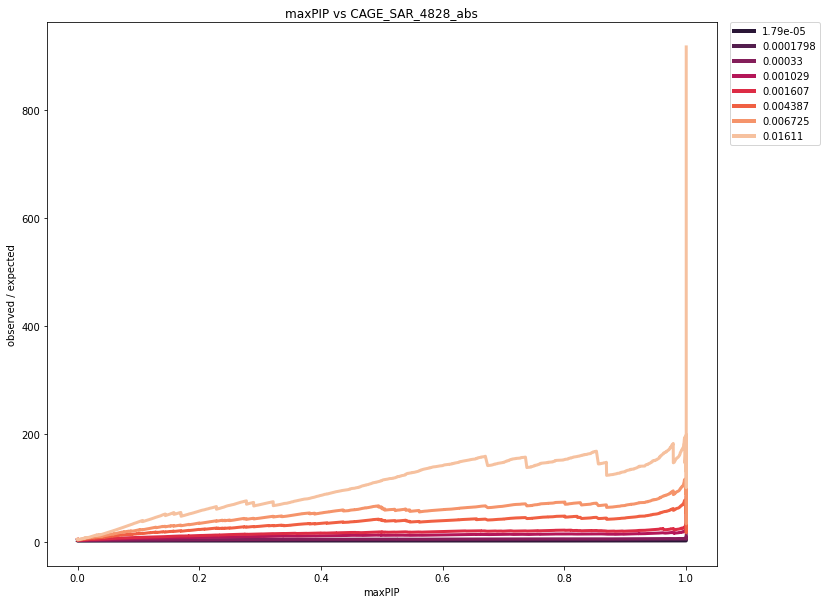

In [26]:
final = final1
import numpy as np
import seaborn as sns

plot_enrichment_curves(final,
                       compare_score='maxPIP', model_score='CAGE_SAR_4828',
                       compare_score_ascending=False, model_score_ascending=False, output_file="enformer_cage_4828_sar_bloodtraits_abs_logfc_x_jsd_x_max_percentile.pdf")